# Bout, Stim, and Duration Post Hoc Analysis(CSV for Database) 

In [35]:
import joblib
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import time
from tkinter import *
import tkinter as tk
from tkinter import filedialog
from tqdm import tqdm
from tqdm import notebook
import itertools
import math
import seaborn as sns
import statistics 
from collections import OrderedDict
import csv
import re

In [36]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles = filedialog.askopenfilename(multiple=True, title='load posthoc-predictions.npy')

%gui tk

infiles

('/Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/predict_video_exp_16.npy',)

### Use for HDC Mice 

In [20]:
filepath = infiles[0]
parts = filepath.split('/')
print(parts)
parts1= re.sub(r'\d', '', parts[-2])
print(parts1)
directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
file_name = ''.join([parts[-3],parts1])  # Join the last two parts
print("Directory Path:", directory_path)
print("File Name:", file_name)


['', 'Users', 'kaycei', 'K on Server (NoMachine)', 'KayCei', 'HDC', 'AH1-KO', '120423-LIGHTS OFF', 'predict_video_exp_16.npy']
-LIGHTS OFF
Directory Path: /Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH1-KO/120423-LIGHTS OFF
File Name: AH1-KO-LIGHTS OFF


### Use for WT Mice 

In [37]:
filepath = infiles[0]
parts = filepath.split('/')
print(parts)
directory_path = '/'.join(parts[:-1])  # Join all parts except the last two
file_name = parts[-4] # Join the last two parts
# Remove numerals (digits) from the file name
#file_name = re.sub(r'\d', '', file_name)
print("Directory Path:", directory_path)
print("File Name:", file_name)


['', 'Users', 'kaycei', 'K on Server (NoMachine)', 'KayCei', 'AD6-D2', 'videos', '071823-rt bilateral sham', 'predict_video_exp_16.npy']
Directory Path: /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham
File Name: AD6-D2


In [38]:
Random_List = [] #creates a array known as random list 
for f in range(len(infiles)):
    arr = np.load(infiles[f])
    Random_List.extend(arr) 
#print(Random_List)

# Total Time of Video in deciseconds

In [39]:
duration_in_deciseconds = len(Random_List)
duration_in_minutes = duration_in_deciseconds / 600
duration_in_frames = duration_in_deciseconds * 3

print('This video is', duration_in_deciseconds, 'deciseconds, which is', duration_in_minutes, 'minutes, which is', duration_in_frames, 'frames')
#print(Random_List)

This video is 39154 deciseconds, which is 65.25666666666666 minutes, which is 117462 frames


## Creating Array

## Time Integration (deciseconds) 

In [40]:
BehaviorTime = []

for index, value in enumerate(Random_List):
    BehaviorTime.append((value, index))

In [41]:
#print(BehaviorTime)

In [42]:
from collections import OrderedDict

# Initialize the behavior_labels dictionary
behavior_labels = OrderedDict({
    0.0: "insignificant",
    1.0: "insignificant",
    2.0: "insignificant",
    3.0: "insignificant",
    4.0: "insignificant",
    5.0: "insignificant",
    6.0: "Rear",
    7.0: "Investigate Type 1",
    8.0: "Investigate Type 2", 
    9.0: "Contra-Itch",
    10.0: "Investigate Type 3",
    11.0: "insignificant",
    12.0: "insignificant",
    13.0: "insignificant",
    14.0: "Contra-Body Groom",
    15.0: "Face Groom Type 1",
    16.0: "Dive/Scrunch",
    17.0: "Head Groom",
    18.0: "Ipsi-Orient",
    19.0: "insignificant",
    20.0: "Face Groom Type 2",
    21.0: "Ipsi-Body Groom",
    22.0: "Ipsi-Itch Type 1",
    23.0: "insignificant",
    24.0: "insignificant",
    25.0: "Paw-Groom",
    26.0: "Locomotion",
    27.0: "insignificant",
    28.0: "Contra-Orient",
})

# Initialize an empty dictionary to store counts for each behavior label
behavior_counts = OrderedDict()

# Iterate through Random_List and count instances for each behavior label
for value, index in BehaviorTime:
    label = behavior_labels.get(value, "Unknown")  # Get the label or "Unknown" if not found
    if label not in behavior_counts:
        behavior_counts[label] = 0  # Initialize the count for the label if not already present
    behavior_counts[label] += 1

# Print the counts for each behavior label in the original order
for label, count in behavior_counts.items():
    print(f"{label},{count}")


Ipsi-Body Groom,2275
Locomotion,3502
insignificant,15675
Contra-Orient,1017
Investigate Type 2,10416
Contra-Itch,1236
Ipsi-Orient,1324
Rear,726
Face Groom Type 1,719
Ipsi-Itch Type 1,253
Contra-Body Groom,1050
Investigate Type 3,618
Dive/Scrunch,188
Investigate Type 1,17
Head Groom,136
Paw-Groom,2


### Ensures you only analyze expected length of  Session 


length_of_session = (int(input("How long was the session in minutes?"))) * 600
print(length_of_session)
BehaviorTime = BehaviorTime[:(length_of_session+1)]

#### Removes all info after selected end time 

In [43]:
print('This video is ', len(BehaviorTime), ' deciseconds, which is', (len(BehaviorTime)/600), 'minutes' )
print()
#print(BehaviorTime)

This video is  39154  deciseconds, which is 65.25666666666666 minutes



## Adds Stim Count and Frame Rate to Array 

## Use if using OBS Studio at 60 FPS

## Use If Recoreded with Real Time Stim at 30FPS

In [44]:

for z in BehaviorTime:
    behavior = z[0]
    time= z[1]
behavior_type_and_duration = []
current_behavior = BehaviorTime[0][0]
current_time = BehaviorTime[0][1]  
duration = 0
stim_count=0
frames = 0

for behavior, time in BehaviorTime:
    if behavior == current_behavior:
        duration += 1
        if duration == 1:
            start_time= current_time
    else:
        if duration==1:
            end_time=start_time+1
        else:
            end_time= start_time + duration
        frames= duration*3
        stim_count= round(duration/3)
        behavior_type_and_duration.append((current_behavior, duration,frames,stim_count,start_time, end_time))
        current_behavior = behavior
        current_time = time
        start_time= time
        duration = 1
        end_time= time+1
        
# Append the final (current_behavior, current_time, count) tuple outside the loop
behavior_type_and_duration.append((current_behavior, duration, frames, stim_count, start_time, end_time))

# Make a copy of the original behavior_type_and_duration list
behaviortdt= list(behavior_type_and_duration)

In [45]:
print(behaviortdt)
#print(len(behaviortdt))

[(21, 2, 6, 1, 0, 2), (26, 1, 3, 0, 2, 3), (13, 2, 6, 1, 3, 5), (21, 1, 3, 0, 5, 6), (13, 1, 3, 0, 6, 7), (21, 2, 6, 1, 7, 9), (13, 2, 6, 1, 9, 11), (26, 1, 3, 0, 11, 12), (1, 1, 3, 0, 12, 13), (28, 2, 6, 1, 13, 15), (27, 1, 3, 0, 15, 16), (8, 3, 9, 1, 16, 19), (26, 1, 3, 0, 19, 20), (28, 1, 3, 0, 20, 21), (9, 1, 3, 0, 21, 22), (26, 1, 3, 0, 22, 23), (18, 1, 3, 0, 23, 24), (1, 1, 3, 0, 24, 25), (9, 2, 6, 1, 25, 27), (1, 3, 9, 1, 27, 30), (9, 1, 3, 0, 30, 31), (6, 2, 6, 1, 31, 33), (1, 6, 18, 2, 33, 39), (6, 1, 3, 0, 39, 40), (15, 1, 3, 0, 40, 41), (1, 3, 9, 1, 41, 44), (26, 1, 3, 0, 44, 45), (21, 2, 6, 1, 45, 47), (22, 1, 3, 0, 47, 48), (21, 1, 3, 0, 48, 49), (9, 4, 12, 1, 49, 53), (28, 2, 6, 1, 53, 55), (9, 5, 15, 2, 55, 60), (28, 1, 3, 0, 60, 61), (6, 1, 3, 0, 61, 62), (28, 1, 3, 0, 62, 63), (6, 2, 6, 1, 63, 65), (14, 1, 3, 0, 65, 66), (22, 1, 3, 0, 66, 67), (21, 1, 3, 0, 67, 68), (22, 1, 3, 0, 68, 69), (21, 5, 15, 2, 69, 74), (1, 1, 3, 0, 74, 75), (21, 2, 6, 1, 75, 77), (22, 1, 3, 0

In [46]:
#length_of_session = (int(input("How long was the session in minutes?"))) * 600 
#print(length_of_session) 
behaviortdt = [tup for tup in behaviortdt if tup[4] <= 39001]

In [47]:
print('This video is ', behaviortdt[-1][-1], ' deciseconds, which is', (behaviortdt[-1][-1]/600), 'minutes' )
print()
#print(behaviortdt)

This video is  39010  deciseconds, which is 65.01666666666667 minutes



## Add Bout Count to the Array 

In [48]:
enumerated_behaviortdt = []
behavior_index = {}  # Dictionary to store behavior and its corresponding index

for behavior, duration, frames, stim_count, start_time, end_time in behaviortdt:
    if behavior not in behavior_index:
        behavior_index[behavior] = 1
    else:
        behavior_index[behavior] += 1
    
    bout = behavior_index[behavior]
    enumerated_behaviortdt.append((behavior,stim_count,frames, bout, duration,start_time,end_time))

print(enumerated_behaviortdt)

[(21, 1, 6, 1, 2, 0, 2), (26, 0, 3, 1, 1, 2, 3), (13, 1, 6, 1, 2, 3, 5), (21, 0, 3, 2, 1, 5, 6), (13, 0, 3, 2, 1, 6, 7), (21, 1, 6, 3, 2, 7, 9), (13, 1, 6, 3, 2, 9, 11), (26, 0, 3, 2, 1, 11, 12), (1, 0, 3, 1, 1, 12, 13), (28, 1, 6, 1, 2, 13, 15), (27, 0, 3, 1, 1, 15, 16), (8, 1, 9, 1, 3, 16, 19), (26, 0, 3, 3, 1, 19, 20), (28, 0, 3, 2, 1, 20, 21), (9, 0, 3, 1, 1, 21, 22), (26, 0, 3, 4, 1, 22, 23), (18, 0, 3, 1, 1, 23, 24), (1, 0, 3, 2, 1, 24, 25), (9, 1, 6, 2, 2, 25, 27), (1, 1, 9, 3, 3, 27, 30), (9, 0, 3, 3, 1, 30, 31), (6, 1, 6, 1, 2, 31, 33), (1, 2, 18, 4, 6, 33, 39), (6, 0, 3, 2, 1, 39, 40), (15, 0, 3, 1, 1, 40, 41), (1, 1, 9, 5, 3, 41, 44), (26, 0, 3, 5, 1, 44, 45), (21, 1, 6, 4, 2, 45, 47), (22, 0, 3, 1, 1, 47, 48), (21, 0, 3, 5, 1, 48, 49), (9, 1, 12, 4, 4, 49, 53), (28, 1, 6, 3, 2, 53, 55), (9, 2, 15, 5, 5, 55, 60), (28, 0, 3, 4, 1, 60, 61), (6, 0, 3, 3, 1, 61, 62), (28, 0, 3, 5, 1, 62, 63), (6, 1, 6, 4, 2, 63, 65), (14, 0, 3, 1, 1, 65, 66), (22, 0, 3, 2, 1, 66, 67), (21, 0, 3,

In [49]:
behavior_labels = {
    0.0: "insignificant",
    1.0: "insignificant",
    2.0: "insignificant",
    3.0: "insignificant",
    4.0: "insignificant",
    5.0: "insignificant",
    6.0: "Rear",
    7.0: "Investigate Type 1",
    8.0: "Investigate Type 2", 
    9.0: "Contra-Itch",
    10.0: "Investigate Type 3",
    11.0: "insignificant",
    12.0: "insignificant",
    13.0: "insignificant",
    14.0: "Contra-Body Groom",
    15.0: "Face Groom Type 1",
    16.0: "Dive/Scrunch",
    17.0: "Head Groom",
    18.0: "Ipsi-Orient",
    19.0: "insignificant",
    20.0: "Face Groom Type 2",
    21.0: "Ipsi-Body Groom",
    22.0: "Ipsi-Itch Type 1",
    23.0: "insignificant",
    24.0: "insignificant",
    25.0: "Paw-Groom",
    26.0: "Locomotion",
    27.0: "insignificant",
    28.0: "Contra-Orient",
}

# Step 1: Initialize transition matrix
transition_matrix = {}

# Step 2: Process the data (starting from index 1)
for i in range(1, len(enumerated_behaviortdt)):
    current_behavior = enumerated_behaviortdt[i][0]
    previous_behavior = enumerated_behaviortdt[i - 1][0]

    if current_behavior not in transition_matrix:
        transition_matrix[current_behavior] = []

    transition_matrix[current_behavior].append(previous_behavior)

# Step 3: Count occurrences and create dictionaries
for behavior, previous_behaviors in transition_matrix.items():
    behavior_counts = {}
    for prev_behavior in previous_behaviors:
        behavior_counts[prev_behavior] = behavior_counts.get(prev_behavior, 0) + 1
    transition_matrix[behavior] = behavior_counts

# Step 4: Replace behavior codes with labels
transition_matrix_with_labels = {}
for behavior, counts in transition_matrix.items():
    behavior_label = behavior_labels.get(behavior, "Unknown")  # Use "Unknown" if not found in mapping
    counts_with_labels = {behavior_labels.get(prev_behavior, "Unknown"): count for prev_behavior, count in counts.items()}
    transition_matrix_with_labels[behavior_label] = counts_with_labels

# Step 5: Print the transition matrix with labels
for behavior_label, counts_with_labels in transition_matrix_with_labels.items():
    print(f"Behavior Label: {behavior_label}:")
    for prev_behavior_label, count in counts_with_labels.items():
        print(f"  - From {prev_behavior_label}: Count {count}")
    print()
    
# Define the file name for the CSV
output_csv_file = f"{directory_path}/{file_name}_transition_matrix.csv"

# Step 6: Save the transition matrix with labels to a CSV file
with open(output_csv_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write the header row
    csv_writer.writerow(["Current Behavior Label", "Previous Behavior Label", "Count"])
    
    # Write the data rows
    for current_behavior_label, counts_with_labels in transition_matrix_with_labels.items():
        for prev_behavior_label, count in counts_with_labels.items():
            csv_writer.writerow([current_behavior_label, prev_behavior_label, count])

print(f"Transition matrix saved to {output_csv_file}")


Behavior Label: Locomotion:
  - From Ipsi-Body Groom: Count 20
  - From insignificant: Count 1
  - From Investigate Type 2: Count 560
  - From Contra-Itch: Count 65
  - From Ipsi-Itch Type 1: Count 14
  - From Investigate Type 3: Count 52
  - From Ipsi-Orient: Count 274
  - From Contra-Body Groom: Count 6
  - From Rear: Count 21
  - From Face Groom Type 1: Count 9
  - From Contra-Orient: Count 149
  - From Dive/Scrunch: Count 3

Behavior Label: insignificant:
  - From Head Groom: Count 1

Behavior Label: Ipsi-Body Groom:
  - From insignificant: Count 4
  - From Locomotion: Count 39
  - From Ipsi-Itch Type 1: Count 92
  - From Contra-Itch: Count 29
  - From Face Groom Type 1: Count 68
  - From Contra-Orient: Count 7
  - From Dive/Scrunch: Count 20
  - From Ipsi-Orient: Count 60
  - From Investigate Type 2: Count 3
  - From Contra-Body Groom: Count 12
  - From Investigate Type 3: Count 8
  - From Paw-Groom: Count 1
  - From Rear: Count 1

Behavior Label: Contra-Orient:
  - From insignifi

Transition matrix heatmap saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/AD6-D2_transition_matrix_heatmap.png


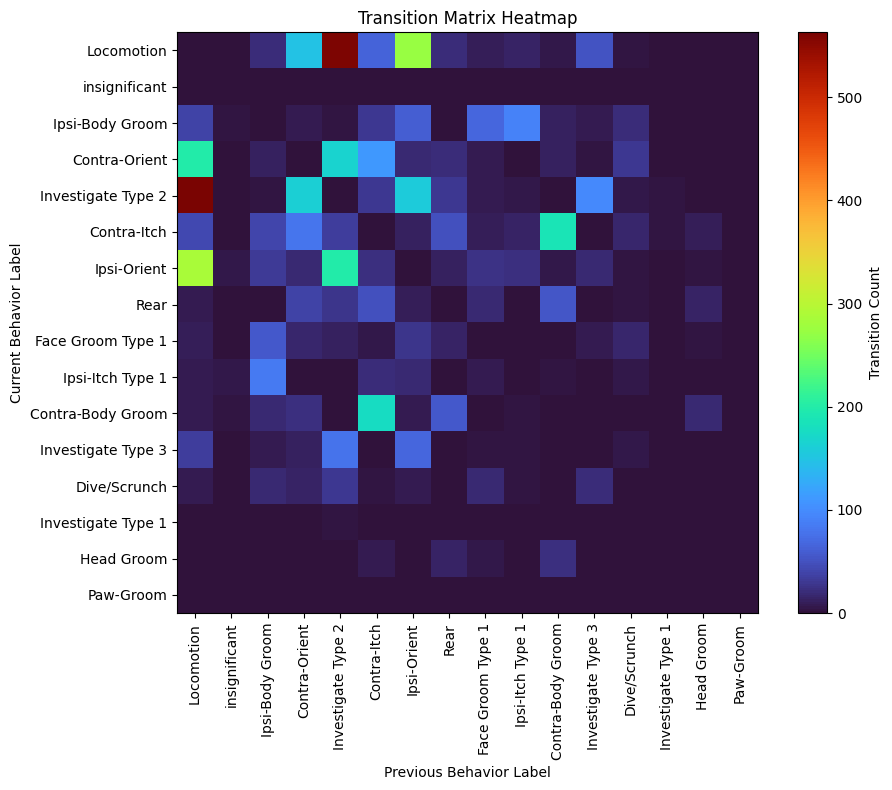

In [50]:

# Extract behavior labels and counts from the transition matrix
behavior_labels = list(transition_matrix_with_labels.keys())
transition_counts = np.zeros((len(behavior_labels), len(behavior_labels)))

for i, current_behavior_label in enumerate(behavior_labels):
    counts_with_labels = transition_matrix_with_labels[current_behavior_label]
    for j, prev_behavior_label in enumerate(behavior_labels):
        transition_counts[i][j] = counts_with_labels.get(prev_behavior_label, 0)

# Create the heatmap plot
plt.figure(figsize=(10, 8))
plt.imshow(transition_counts, cmap='turbo', interpolation='nearest')

# Set axis labels and ticks
plt.xticks(np.arange(len(behavior_labels)), behavior_labels, rotation=90)
plt.yticks(np.arange(len(behavior_labels)), behavior_labels)
plt.xlabel("Previous Behavior Label")
plt.ylabel("Current Behavior Label")
plt.colorbar(label="Transition Count")

# Show the plot or save it as an image
plt.title("Transition Matrix Heatmap")
plt.tight_layout()

# Uncomment the line below to display the plot
#plt.show()

# Uncomment the lines below to save the plot as an image
# Save the current figure as an image
plt.gcf().savefig(f"{directory_path}/{file_name}_transition_matrix_heatmap.png", dpi=300)
print(f"Transition matrix heatmap saved as {directory_path}/{file_name}_transition_matrix_heatmap.png")

plt.show()
plt.close()

Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/Transition plots/Locomotion_transition_plot.png
Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/Transition plots/Ipsi-Body_Groom_transition_plot.png
Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/Transition plots/Contra-Orient_transition_plot.png
Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/Transition plots/Investigate_Type_2_transition_plot.png
Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/Transition plots/Contra-Itch_transition_plot.png
Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/videos/071823-rt bilateral sham/Transition plots/Ipsi-Orient_transition_plot.png
Histogram saved as /Users/kaycei/K on Server (NoMachine)/KayCei/AD6-D2/video

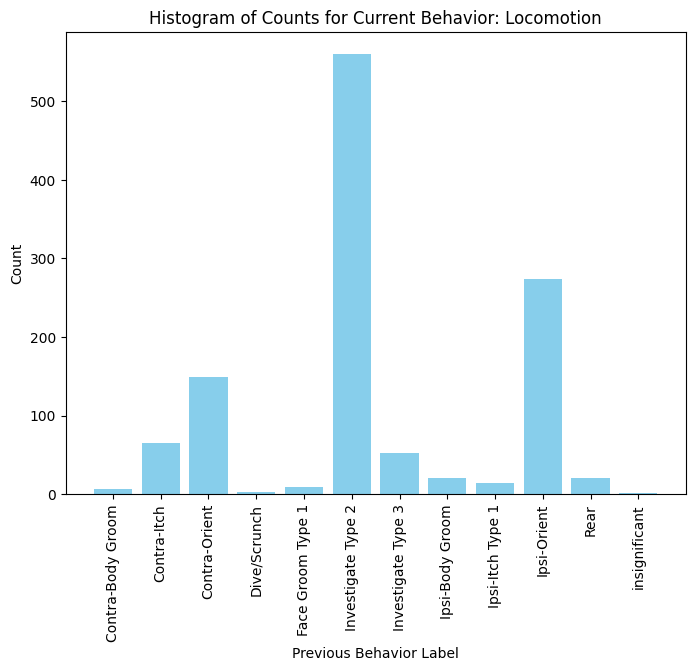

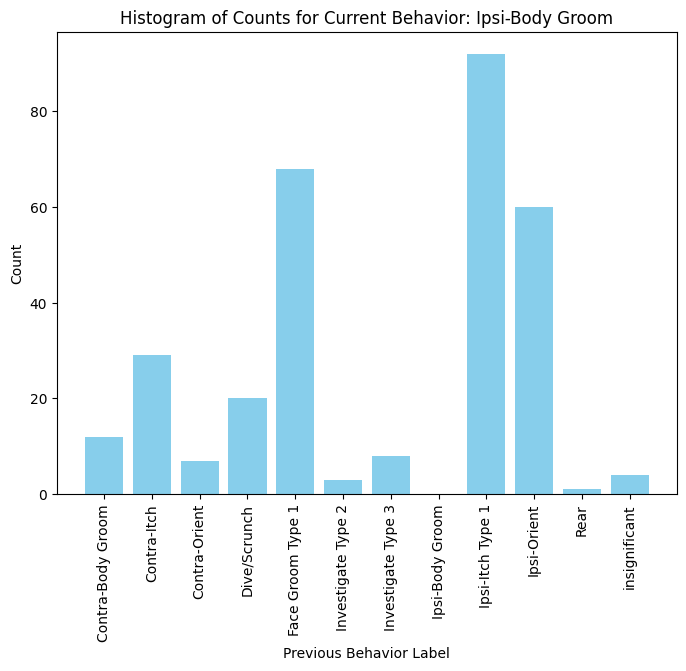

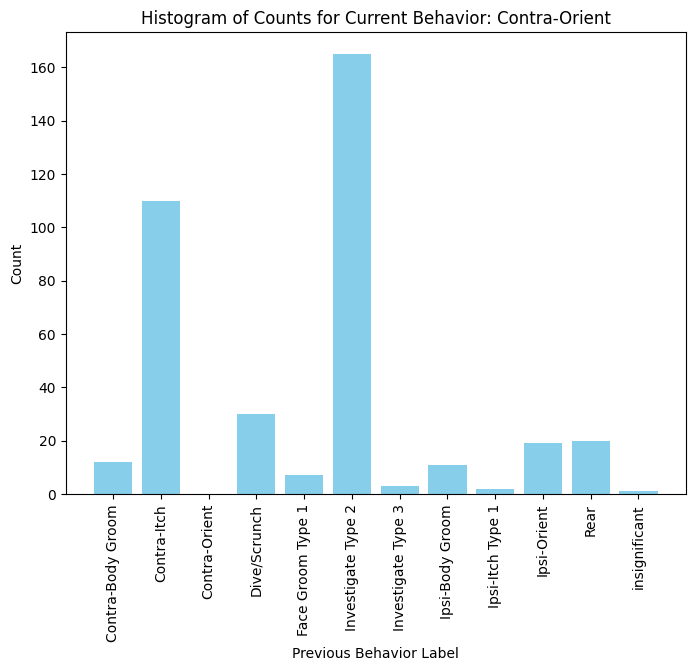

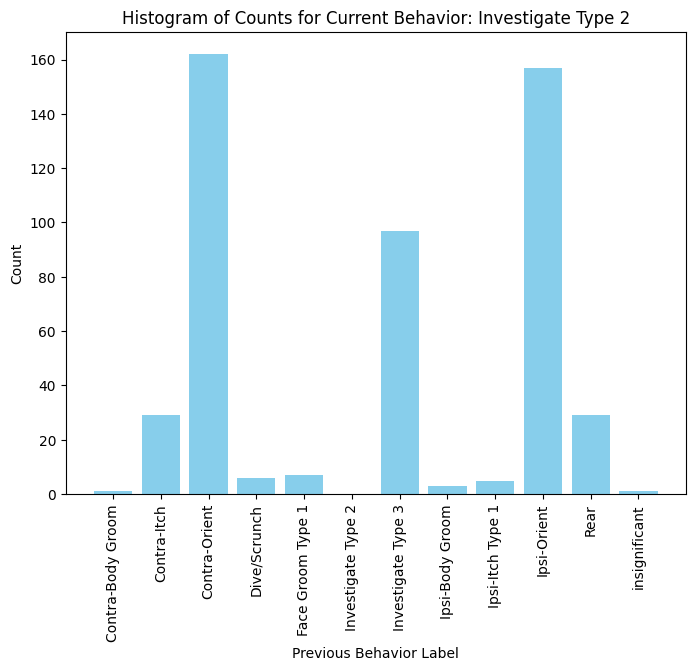

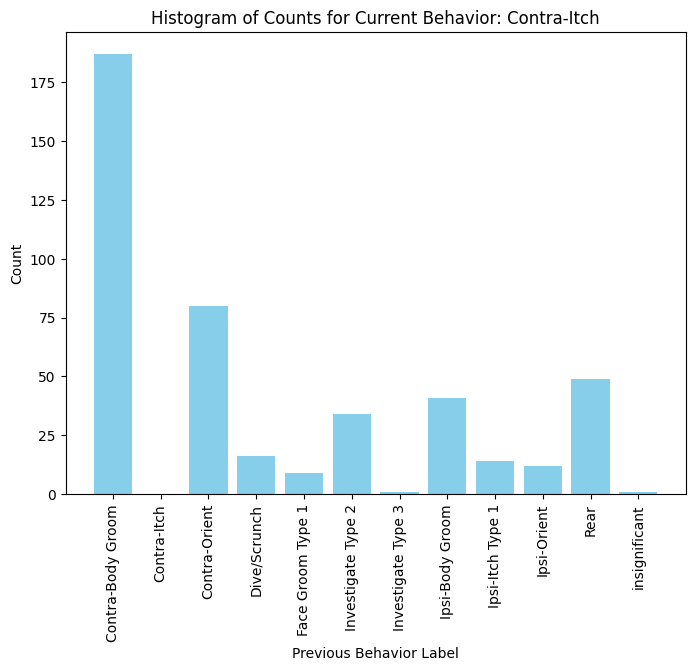

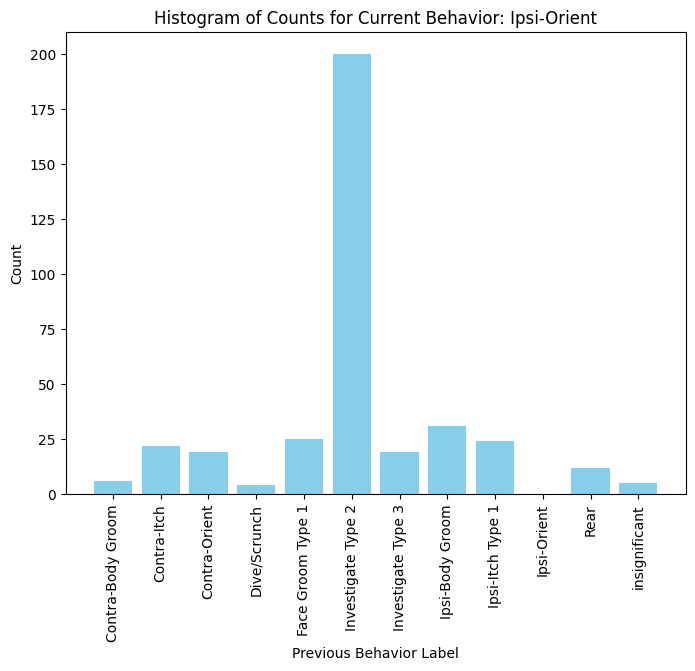

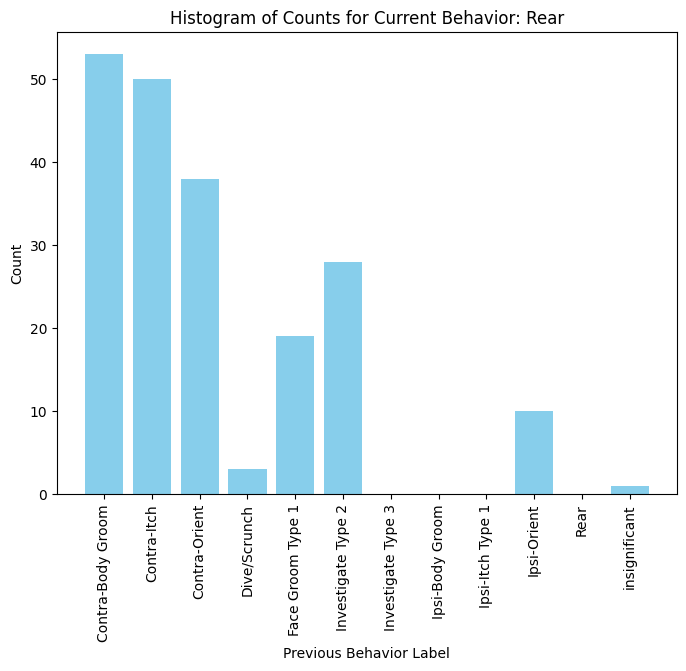

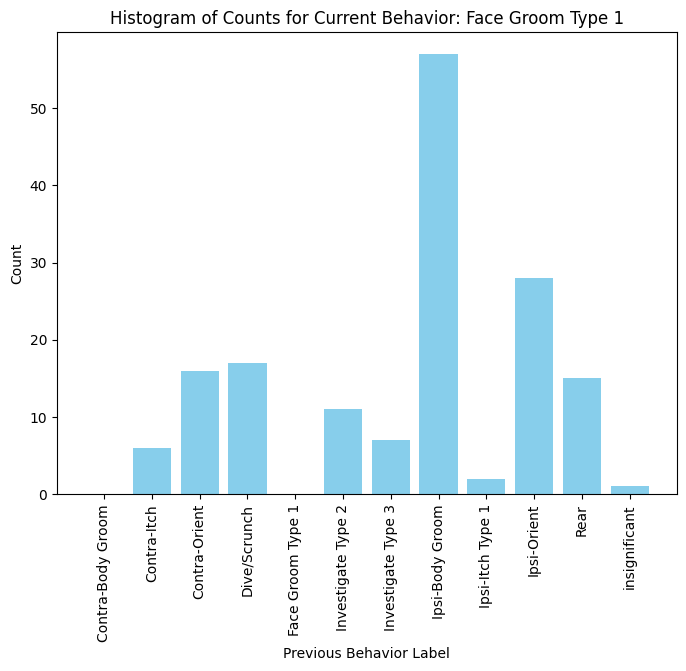

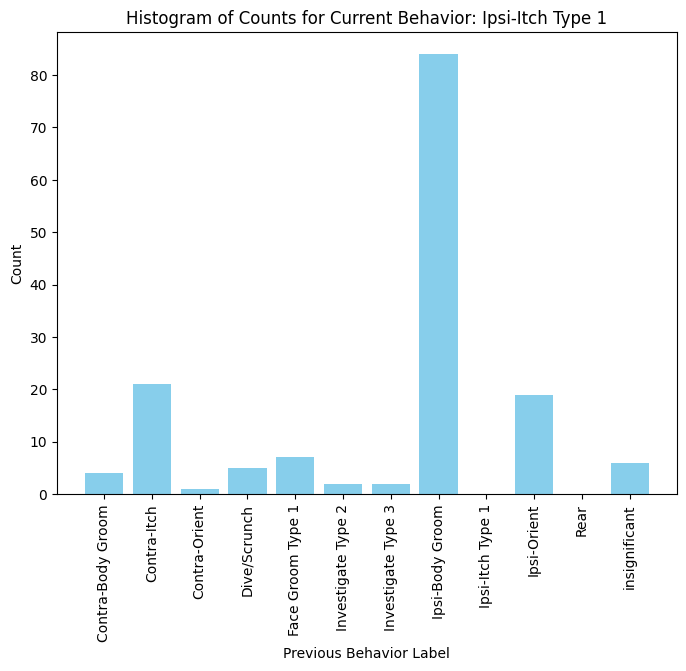

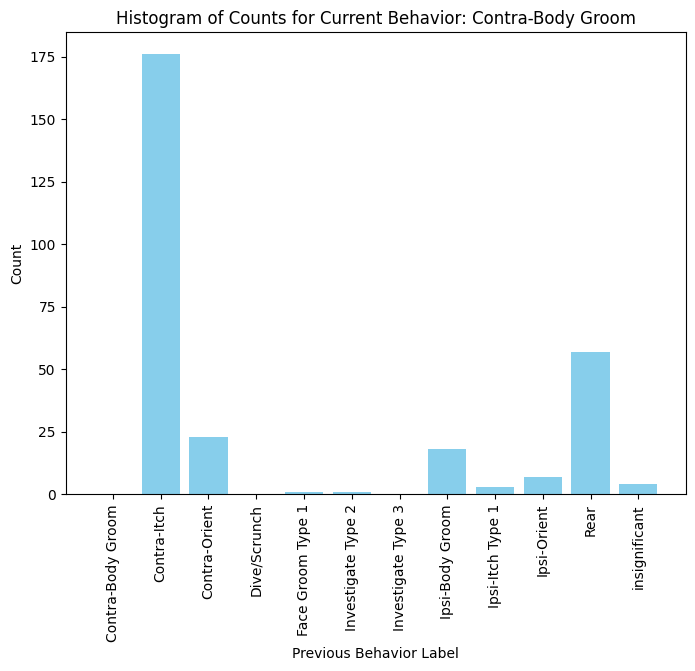

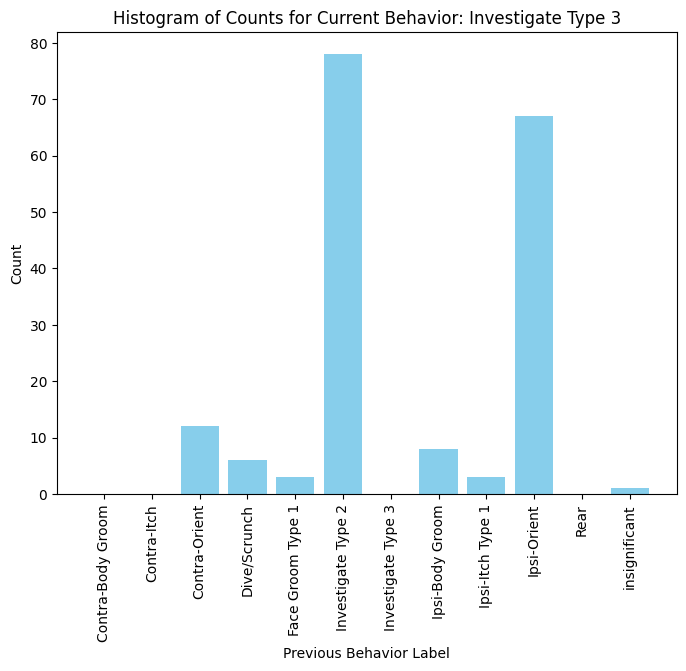

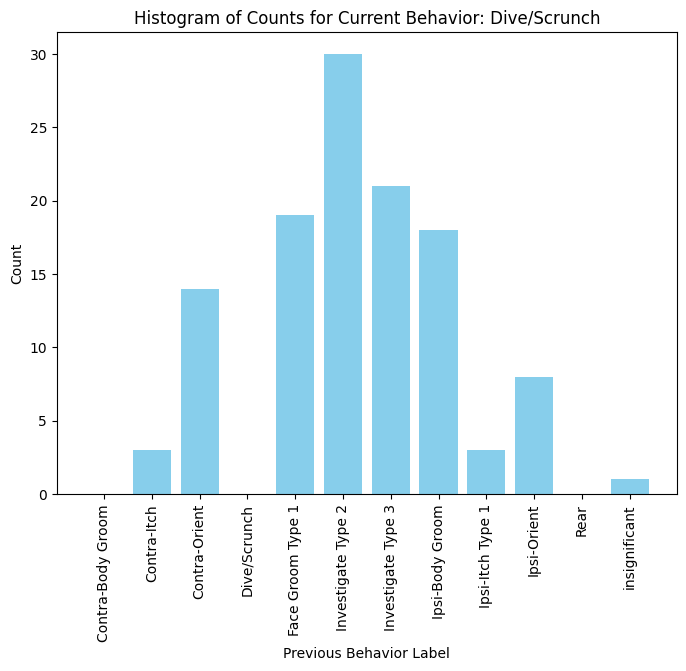

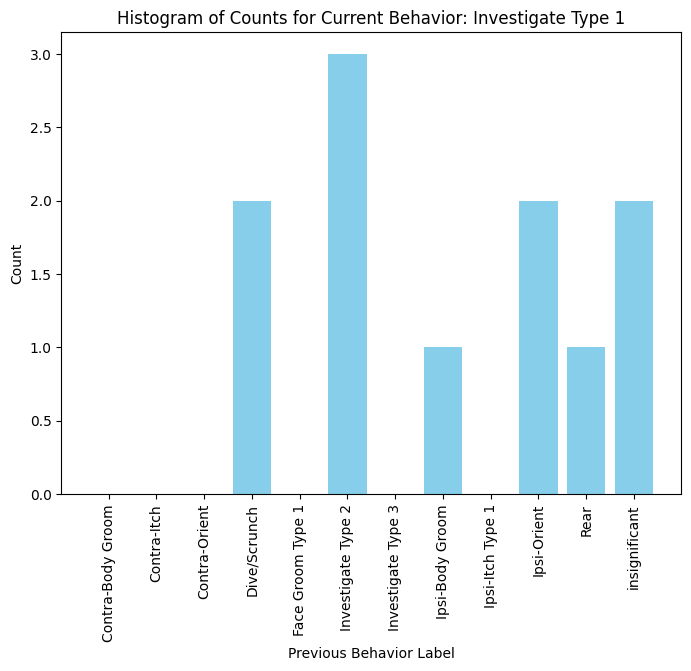

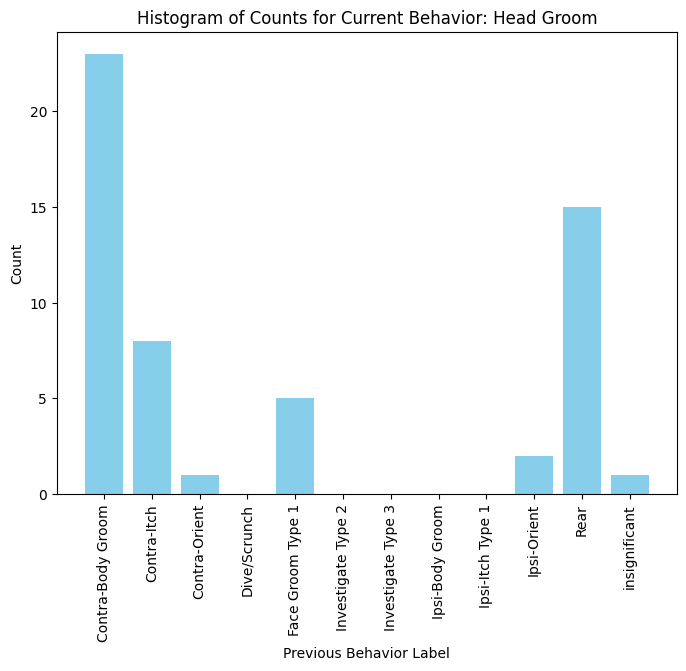

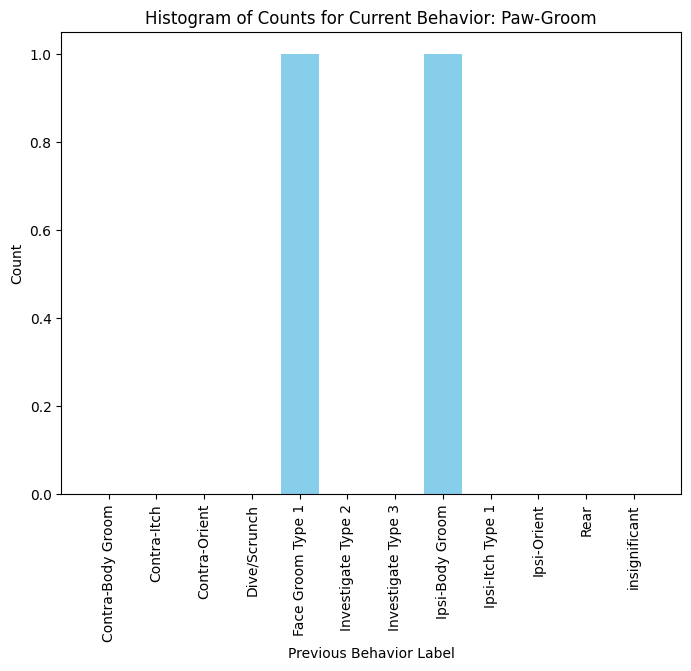

In [51]:
# Define the directory path for saving plots
transition_plots_dir = os.path.join(directory_path, "Transition plots")

# Create the "Transition plots" directory if it doesn't exist
os.makedirs(transition_plots_dir, exist_ok=True)

# Define a list of current behavior labels to exclude (adjust as needed)
exclude_labels = ["insignificant"]  # Add labels to be excluded

# Define a sorted list of previous behavior labels (based on the first behavior encountered)
sorted_previous_behaviors = sorted(list(transition_matrix_with_labels.values())[0].keys())

# Iterate through each current behavior in the transition matrix
for current_behavior_label, counts_with_labels in transition_matrix_with_labels.items():
    # Check if the current behavior label is in the exclusion list
    if current_behavior_label in exclude_labels:
        continue  # Skip this current behavior label

    # Initialize counts for all sorted_previous_behaviors to 0
    counts = [counts_with_labels.get(prev, 0) for prev in sorted_previous_behaviors]

    # Create a new figure for each histogram
    plt.figure(figsize=(8, 6))

    # Create the histogram plot
    plt.bar(sorted_previous_behaviors, counts, color='skyblue')

    # Set axis labels and title
    plt.xlabel("Previous Behavior Label")
    plt.ylabel("Count")
    
    # Modify the current behavior label for the filename
    # Replace any special characters or spaces with underscores
    filename_behavior_label = current_behavior_label.replace('/', '_').replace(' ', '_')

    # Set the modified behavior label as the title
    plt.title(f"Histogram of Counts for Current Behavior: {current_behavior_label}")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Uncomment the line below to display each plot
    # plt.show()

    # Define the filename for saving the plot
    plot_filename = os.path.join(transition_plots_dir, f"{filename_behavior_label}_transition_plot.png")

    # Save the plot as an image in the "Transition plots" directory
    plt.savefig(plot_filename, dpi=300)
    print(f"Histogram saved as {plot_filename}")

# To display all plots at once (if desired)
#plt.show()

# Stim Count Calcultaion

In [99]:
#BCBDT = []

# Calculate durations and update BCBDT
#for behavior, duration, frames, bout, start_time, end_time in enumerated_behaviortdt:
    #stim_count = round(duration / 3)
    #if stim_count < 1:
        #stim_count = 0
    #if stim_count > 0:
        #BCBDT.append((behavior, duration, frames, bout, stim_count, start_time, end_time))

# Print the modified BCBDT
#print("Modified BCBDT:", BCBDT)

# Assign enumerated_behaviortdt to BCBDST
BCBDST = enumerated_behaviortdt


In [100]:
behavior_labels = {
    0.0: "insignificant",
    1.0: "insignificant",
    2.0: "insignificant",
    3.0: "insignificant",
    4.0: "insignificant",
    5.0: "insignificant",
    6.0: "Rear",
    7.0: "Investigate Type 1",
    8.0: "Investigate Type 2", 
    9.0: "Contra-Itch",
    10.0: "Investigate Type 3",
    11.0: "insignificant",
    12.0: "insignificant",
    13.0: "insignificant",
    14.0: "Contra-Body Groom",
    15.0: "Face Groom Type 1",
    16.0: "Dive/Scrunch",
    17.0: "Head Groom",
    18.0: "Ipsi-Orient",
    19.0: "insignificant",
    20.0: "Face Groom Type 2",
    21.0: "Ipsi-Body Groom",
    22.0: "Ipsi-Itch Type 1",
    23.0: "insignificant",
    24.0: "insignificant",
    25.0: "Paw-Groom",
    26.0: "Locomotion",
    27.0: "insignificant",
    28.0: "Contra-Orient",
}

bdbt_dict = {}  # Dictionary to store lists of behaviors

for behavior,stim_count,frames, bout, duration,start_time,end_time in BCBDST:
    behavior_label = behavior_labels.get(behavior, "Unknown Behavior")
    if behavior_label not in bdbt_dict:
        bdbt_dict[behavior_label] = []
    bdbt_dict[behavior_label].append((behavior, stim_count, frames, bout, duration, start_time,end_time))


In [101]:
print(bdbt_dict)

{'Locomotion': [(26, 1, 24, 1, 4, 0, 4), (26, 0, 6, 2, 1, 6, 7), (26, 0, 6, 3, 1, 12, 13), (26, 0, 6, 4, 1, 14, 15), (26, 0, 6, 5, 1, 22, 23), (26, 0, 6, 6, 1, 30, 31), (26, 4, 162, 7, 27, 40, 67), (26, 2, 78, 8, 13, 69, 82), (26, 2, 54, 9, 9, 83, 92), (26, 2, 60, 10, 10, 95, 105), (26, 0, 18, 11, 3, 106, 109), (26, 0, 6, 12, 1, 111, 112), (26, 0, 6, 13, 1, 116, 117), (26, 0, 18, 14, 3, 123, 126), (26, 0, 12, 15, 2, 129, 131), (26, 1, 48, 16, 8, 132, 140), (26, 0, 6, 17, 1, 151, 152), (26, 2, 54, 18, 9, 154, 163), (26, 5, 174, 19, 29, 175, 204), (26, 0, 6, 20, 1, 205, 206), (26, 0, 12, 21, 2, 208, 210), (26, 0, 12, 22, 2, 215, 217), (26, 0, 6, 23, 1, 220, 221), (26, 0, 18, 24, 3, 226, 229), (26, 2, 60, 25, 10, 236, 246), (26, 1, 30, 26, 5, 247, 252), (26, 0, 6, 27, 1, 258, 259), (26, 1, 42, 28, 7, 262, 269), (26, 0, 12, 29, 2, 271, 273), (26, 0, 6, 30, 1, 275, 276), (26, 2, 90, 31, 15, 278, 293), (26, 1, 42, 32, 7, 296, 303), (26, 0, 6, 33, 1, 305, 306), (26, 0, 6, 34, 1, 315, 316), (2

In [102]:
keys_list = bdbt_dict.keys()
print(keys_list)

dict_keys(['Locomotion', 'Ipsi-Orient', 'Dive/Scrunch', 'Face Groom Type 1', 'Contra-Orient', 'Investigate Type 2', 'Investigate Type 1', 'Investigate Type 3', 'insignificant', 'Contra-Itch', 'Ipsi-Itch Type 1', 'Ipsi-Body Groom', 'Rear', 'Contra-Body Groom', 'Paw-Groom', 'Head Groom', 'Face Groom Type 2'])


In [103]:
# Calculate elapsed times and average for each behavior
behavior_averages = {}

for behavior_label, behavior_data in bdbt_dict.items():
    elapsed_times = []
    for i in range(len(behavior_data) - 1):
        elapsed_time = behavior_data[i + 1][-2] - behavior_data[i][-1]
        elapsed_times.append(elapsed_time)
    
    if elapsed_times:
        average_elapsed_time = sum(elapsed_times) / len(elapsed_times)
        behavior_averages[behavior_label] = average_elapsed_time / 10

# Sort behavior averages from lowest to highest
sorted_averages = sorted(behavior_averages.items(), key=lambda x: x[1])

# Print the sorted table
print("Behavior\tAverage Elapsed Time")
print("--------------------------------")
for behavior, average in sorted_averages:
    print(f"{behavior}\t{average}")
    
# Save the results to a CSV file
output_file_path = f"{directory_path}/Elapsed Time of {file_name}.csv"

with open(output_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Behavior", "Average Elapsed Time(seconds)"])
    
    for behavior, average in sorted_averages:
        csv_writer.writerow([behavior, average])

print(f"Results saved to {output_file_path}")

Behavior	Average Elapsed Time
--------------------------------
Locomotion	0.6175923718712754
Investigate Type 2	0.6532323960586398
Ipsi-Orient	1.5054995801847189
insignificant	1.510635593220339
Contra-Orient	1.971843095110156
Contra-Itch	4.933947368421053
Investigate Type 3	6.509482758620689
Investigate Type 1	6.9751391465677175
Dive/Scrunch	8.011482254697286
Face Groom Type 1	11.182840236686392
Ipsi-Itch Type 1	17.123318385650226
Rear	20.780337078651687
Ipsi-Body Groom	53.3
Head Groom	58.87966101694915
Contra-Body Groom	93.6128205128205
Paw-Groom	108.596875
Face Groom Type 2	183.29166666666669
Results saved to /Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/120523-LIGHTS OFF/Elapsed Time of AH4-KO-LIGHTS OFF.csv


## Stim Count and Average Duration 

+--------------------+---------------------------+
|        Key         | Average Duration(seconds) |
+--------------------+---------------------------+
|     Locomotion     |           0.312           |
|    Ipsi-Orient     |           0.132           |
|    Dive/Scrunch    |           0.12            |
| Face Groom Type 1  |           0.19            |
|   Contra-Orient    |           0.123           |
| Investigate Type 2 |           0.284           |
| Investigate Type 1 |           0.244           |
| Investigate Type 3 |           0.192           |
|   insignificant    |           0.132           |
|    Contra-Itch     |           0.149           |
|  Ipsi-Itch Type 1  |           0.104           |
|  Ipsi-Body Groom   |           0.107           |
|        Rear        |           0.151           |
| Contra-Body Groom  |           0.11            |
|     Paw-Groom      |           0.121           |
|     Head Groom     |           0.143           |
| Face Groom Type 2  |         

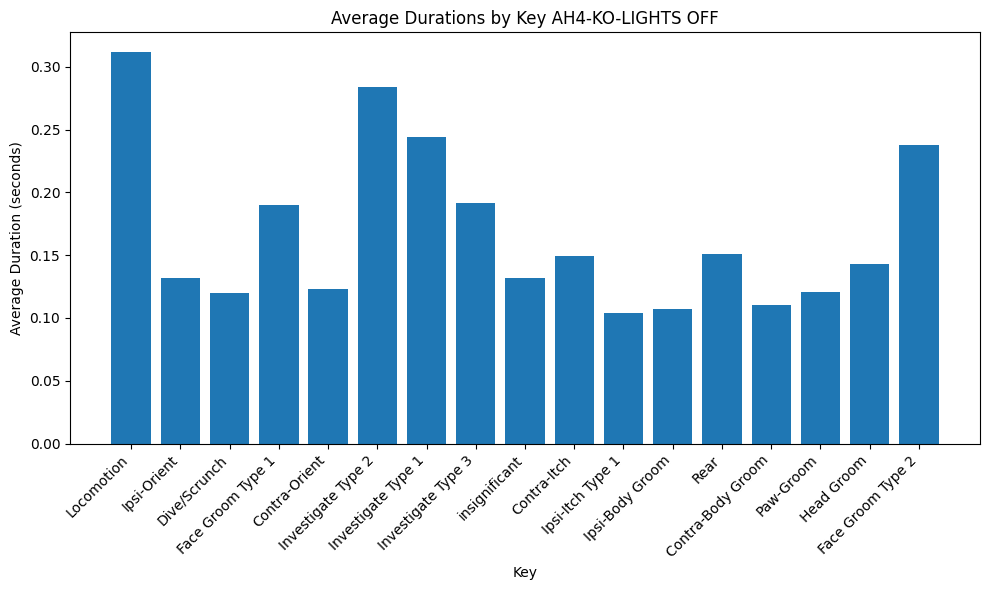

In [104]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import csv

stimcount_by_key = {}

def round_float(value):
    return round(value, 3)

average_duration_by_key = {}

for key, tuples_list in bdbt_dict.items():
    #if key=='insignificant':
        #continue #skip "insignificant" key and its data
    durations = [tuple_item[4] for tuple_item in tuples_list]
    average_duration = ((sum(durations) / len(durations))/10)
    average_duration_by_key[key] = round_float(average_duration)

table_data = [(key, avg_duration) for key, avg_duration in average_duration_by_key.items()]
headers = ["Key", "Average Duration(seconds)"]

table = tabulate(table_data, headers, tablefmt="pretty")
print(table)

# Create a dictionary for the CSV data
csv_data = {f"{file_name}": average_duration_by_key}

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(average_duration_by_key.keys(), average_duration_by_key.values())
plt.xlabel("Key")
plt.ylabel("Average Duration (seconds)")
plt.title(f"Average Durations by Key {file_name}")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Use the directory_path as the output directory
output_directory = directory_path
print(output_directory)
# Save the plot as within the output directory
plot_filename = os.path.join(output_directory, f"{file_name} Duration.png")
plt.savefig(plot_filename)

# Save the CSV data to a CSV file within the output directory
csv_filename = os.path.join(output_directory, f"{file_name}-Duration data.csv")
with open(csv_filename, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    for dictionary_name, data_dict in csv_data.items():
        csv_writer.writerow([dictionary_name])  # Write the dictionary name as a header
        csv_writer.writerow(["Key", "Average Duration (seconds)"])
        for key, avg_duration in data_dict.items():
            csv_writer.writerow([key, avg_duration])

print(f"Plot saved as: {plot_filename}")
print(f"CSV data saved as: {csv_filename}")



In [105]:
# Sort the table_data by average duration in descending order
sorted_table_data = sorted(table_data, key=lambda x: x[1], reverse=True)

# Create a sorted table
sorted_table = tabulate(sorted_table_data, headers, tablefmt="pretty")

# Print the sorted table
print(sorted_table)

+--------------------+---------------------------+
|        Key         | Average Duration(seconds) |
+--------------------+---------------------------+
|     Locomotion     |           0.312           |
| Investigate Type 2 |           0.284           |
| Investigate Type 1 |           0.244           |
| Face Groom Type 2  |           0.238           |
| Investigate Type 3 |           0.192           |
| Face Groom Type 1  |           0.19            |
|        Rear        |           0.151           |
|    Contra-Itch     |           0.149           |
|     Head Groom     |           0.143           |
|    Ipsi-Orient     |           0.132           |
|   insignificant    |           0.132           |
|   Contra-Orient    |           0.123           |
|     Paw-Groom      |           0.121           |
|    Dive/Scrunch    |           0.12            |
| Contra-Body Groom  |           0.11            |
|  Ipsi-Body Groom   |           0.107           |
|  Ipsi-Itch Type 1  |         

##  Number of Bouts

+--------------------+-------------+
|        Key         | Total Bouts |
+--------------------+-------------+
|     Locomotion     |    4196     |
|    Ipsi-Orient     |    2383     |
|    Dive/Scrunch    |     480     |
| Face Groom Type 1  |     339     |
|   Contra-Orient    |    1862     |
| Investigate Type 2 |    4162     |
| Investigate Type 1 |     540     |
| Investigate Type 3 |     581     |
|   insignificant    |    2361     |
|    Contra-Itch     |     761     |
|  Ipsi-Itch Type 1  |     224     |
|  Ipsi-Body Groom   |     72      |
|        Rear        |     179     |
| Contra-Body Groom  |     40      |
|     Paw-Groom      |     33      |
|     Head Groom     |     60      |
| Face Groom Type 2  |     13      |
+--------------------+-------------+
/Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/120523-LIGHTS OFF
Plot saved as: /Users/kaycei/K on Server (NoMachine)/KayCei/HDC/AH4-KO/120523-LIGHTS OFF/AH4-KO-LIGHTS OFF Bout.png
CSV data saved as: /Users/kaycei/

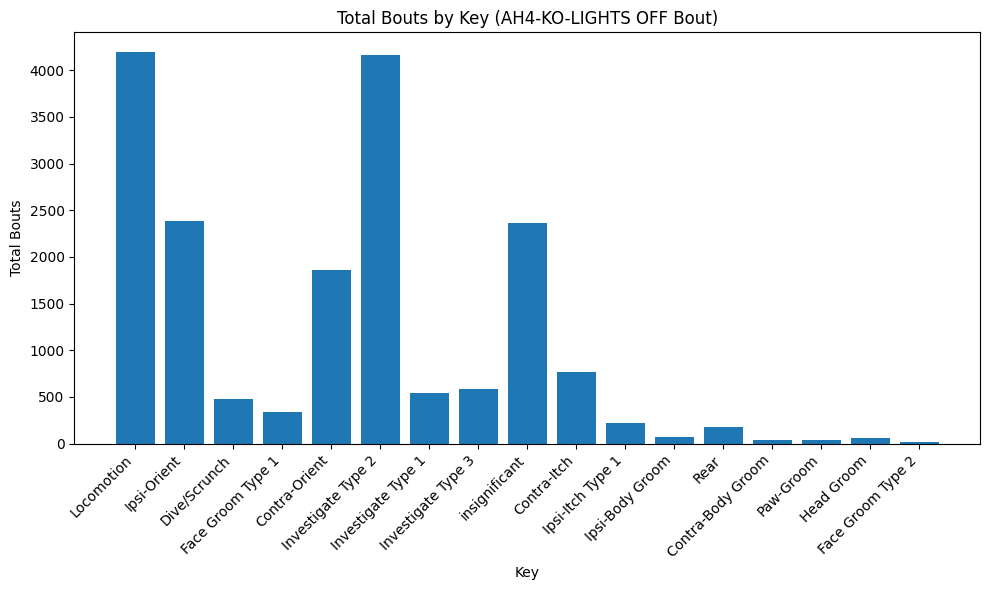

In [106]:
bout_by_key = {}

for key, tuples_list in bdbt_dict.items():
    #if key=='insignificant':
        #continue #skip "insignificant" key and its data
    bouts = [tuple_item[3] for tuple_item in tuples_list]
    sum_of_bouts = len(bouts)
    bout_by_key[key] = sum_of_bouts

table_data = [(key, sum_value) for key, sum_value in bout_by_key.items()]
headers = ["Key", "Total Bouts"]

table = tabulate(table_data, headers, tablefmt="pretty")
print(table)

# Create a dictionary for the CSV data
csv_data_bouts = {f"{file_name}": bout_by_key}
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(bout_by_key.keys(), bout_by_key.values())
plt.xlabel("Key")
plt.ylabel("Total Bouts")
plt.title(f"Total Bouts by Key ({file_name} Bout)")
plt.xticks(rotation=45, ha='right')  # Set the x-axis ticks and labels
plt.tight_layout()

# Use the directory_path as the output directory
output_directory = directory_path
print(output_directory)

# Ensure the output directory exists, and create it if it doesn't
os.makedirs(output_directory, exist_ok=True)

# Save the plot as "AH1 Duration.png" within the output directory
plot_filename = os.path.join(output_directory, f"{file_name} Bout.png")
plt.savefig(plot_filename)

# Save the CSV data to a CSV file within the output directory
csv_filename = os.path.join(output_directory, f"{file_name}- Bout data.csv")
with open(csv_filename, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    for dictionary_name, data_dict in csv_data_bouts.items():
        csv_writer.writerow([dictionary_name])  # Write the dictionary name as a header
        csv_writer.writerow(["Key", "Total Bouts"])
        for key, sum_value in data_dict.items():
            csv_writer.writerow([key, sum_value])

print(f"Plot saved as: {plot_filename}")
print(f"CSV data saved as: {csv_filename}")


In [107]:
# Sort the table_data by average duration in descending order
sorted_table_data = sorted(table_data, key=lambda x: x[1], reverse=True)

# Create a sorted table
sorted_table = tabulate(sorted_table_data, headers, tablefmt="pretty")

# Print the sorted table
print(sorted_table)

+--------------------+-------------+
|        Key         | Total Bouts |
+--------------------+-------------+
|     Locomotion     |    4196     |
| Investigate Type 2 |    4162     |
|    Ipsi-Orient     |    2383     |
|   insignificant    |    2361     |
|   Contra-Orient    |    1862     |
|    Contra-Itch     |     761     |
| Investigate Type 3 |     581     |
| Investigate Type 1 |     540     |
|    Dive/Scrunch    |     480     |
| Face Groom Type 1  |     339     |
|  Ipsi-Itch Type 1  |     224     |
|        Rear        |     179     |
|  Ipsi-Body Groom   |     72      |
|     Head Groom     |     60      |
| Contra-Body Groom  |     40      |
|     Paw-Groom      |     33      |
| Face Groom Type 2  |     13      |
+--------------------+-------------+


## Behavior of Interest

In [108]:
for file_path in infiles: # if taking from Z Drive 
    folders = (os.path.dirname(file_path)).split('/')
    print(folders)
    print(len(folders))
    # Check if there are at least 5 elements in the 'folders' list
    if len(folders) >= 5:
        fol3 = folders[3].split('-')  # Split element at position 3 by hyphen
        fol4 = folders[4].split('-')  # Split element at position 4 by hyphen
        
        print("Folder 3:", fol3)
        print("Folder 4:", fol4)
    else:
        print("The folder path does not have enough elements to access positions 3 and 4.")
    

['', 'Users', 'kaycei', 'K on Server (NoMachine)', 'KayCei', 'HDC', 'AH4-KO', '120523-LIGHTS OFF']
8
Folder 3: ['K on Server (NoMachine)']
Folder 4: ['KayCei']


## Creating CSV

In [20]:
rounded_dict = {}

for key, value_list in bdbt_dict.items():
    rounded_values = [
        (
            round(v[0]),     # Rounding and converting to integer
            v[1], v[2], v[3], v[4],
            round(v[5], 2),  # Rounding the sixth float value
            round(v[6], 2)   # Rounding the seventh float value
        )
        for v in value_list
    ]
    rounded_dict[key] = rounded_values

#print(rounded_dict)

bdbt_dict=rounded_dict
#print(bdbt_dict)

In [21]:
from json import dumps
string_bdbt_dict=dumps(bdbt_dict)

In [22]:
# Find the start index of the first '{' character
start_index = string_bdbt_dict.index('{')

# Find the end index of the last '}' character
end_index = string_bdbt_dict.rindex('}') + 1

# Extract the dictionary portion of the string
dict_str = string_bdbt_dict[start_index:end_index]

# Find the start indices of key-value pairs using '":'
key_value_end = []
for pos, char in enumerate(dict_str):
    if dict_str[pos:pos+3] == '": ':
        key_value_end.append(pos)
        
#print(key_value_end)      

# Initialize lists to store extracted keys and values
keys = []
values = []
value_ends=[]

# Iterate through the start indices of key-value pairs
for key_value_start in key_value_end:
    # Find the start index of the value by searching for '[[' after the key-value pair
    value_start = dict_str.find('[[', key_value_start) + 1
    
    # Find the end index of the value by searching for ']]' after the value_start
    value_end = dict_str.find(']]', value_start)+ 2
    value_ends.append(value_end)

    # Extract the value using the calculated start and end indices
    value = dict_str[value_start:value_end]
    values.append(value)
    # Extract the key using the portion of the string before the '":'
    if key_value_start == key_value_end[0]:
        key = dict_str[2:key_value_start].strip()
        keys.append(key)
    else:
        key = dict_str[value_ends[-2]+ 3:key_value_start].strip()
        keys.append(key)
        
#print(values)
#print(value_ends)
modified_values = {}  # Initialize an empty dictionary to store modified values

# Iterate through the keys and values
for key, value in zip(keys, values):
    modified_value = value.replace(" ", "").replace("],", "]").replace("]]","]")
    modified_values[key] = modified_value

In [33]:
keys_to_write = ["Rear", "Investigate Type 1", "Investigate Type 2",
                 "Contra-Itch", "Investigate Type 3", "Contra-Body Groom",
                 "Face Groom Type 1", "Dive/Scrunch", "Head Groom", "Ipsi-Orient",
                 "Face Groom Type 2", "Ipsi-Body Groom", "Ipsi-Itch Type 1",
                 "Paw-Groom", "Locomotion", "Contra-Orient"]

In [34]:
# Create a dictionary to hold cleaned and possibly split values
cleaned_values = {}

In [35]:
# Iterate through the keys and values, cleaning and splitting if needed
for key in keys_to_write:
    value = modified_values[key].strip()
    
    if len(value) > 32500:
        # Find the last "]" before 32500 characters
        split_index = value.rfind("]", 0, 32500)
        
        if split_index != -1:
            # Split the value into two parts
            part1 = value[:split_index + 1]  # Include the last "]"
            part2 = value[split_index + 1:]
            
            cleaned_values[key] = part1  # Store the first part
            
            continue_key = f"{key} Continue"
            continue_count = 1
            
            while len(part2) > 32500:
                continue_count += 1
                split_index = part2.rfind("]", 0, 32500)  # Find the last "]" in the remaining portion
                part1 = part2[:split_index + 1]
                part2 = part2[split_index + 1:]
                cleaned_values[f"{key} Continue {continue_count}"] = part1
            cleaned_values[f"{key} Continue {continue_count + 1}"] = part2  # Store the remaining part
            
        else:
            # If "]" is not found, just store the value as it is
            cleaned_values[key] = value
    else:
        cleaned_values[key] = value


In [36]:
# Format specific values in cleaned_values dictionary
formatted_values = {'"{}"'.format(key): value for key, value in cleaned_values.items()}

In [37]:
# Print the keys and lengths of values in cleaned_values dictionary
for key, value in cleaned_values.items():
    print(key, len(value))

Rear 860
Investigate Type 1 15822
Investigate Type 2 32499
Investigate Type 2 Continue 2 32500
Investigate Type 2 Continue 3 32485
Investigate Type 2 Continue 4 25537
Contra-Itch 15830
Investigate Type 3 17488
Contra-Body Groom 1471
Face Groom Type 1 7540
Dive/Scrunch 6670
Head Groom 1129
Ipsi-Orient 32500
Ipsi-Orient Continue 2 10807
Face Groom Type 2 860
Ipsi-Body Groom 2482
Ipsi-Itch Type 1 4179
Paw-Groom 1595
Locomotion 32495
Locomotion Continue 2 32500
Locomotion Continue 3 32176
Contra-Orient 30189


In [40]:
# Initialize the list of behavior keys you want to include in mouse_data
behavior_keys = list(cleaned_values.keys())

In [41]:
print(behavior_keys)

['Rear', 'Investigate Type 1', 'Investigate Type 2', 'Investigate Type 2 Continue 2', 'Investigate Type 2 Continue 3', 'Investigate Type 2 Continue 4', 'Contra-Itch', 'Investigate Type 3', 'Contra-Body Groom', 'Face Groom Type 1', 'Dive/Scrunch', 'Head Groom', 'Ipsi-Orient', 'Ipsi-Orient Continue 2', 'Face Groom Type 2', 'Ipsi-Body Groom', 'Ipsi-Itch Type 1', 'Paw-Groom', 'Locomotion', 'Locomotion Continue 2', 'Locomotion Continue 3', 'Contra-Orient']


In [ ]:
import os
import csv

keys_to_write = ["Rear", "Investigate Type 1", "Investigate Type 2",
                 "Contra-Itch","Investigate Type 3", "Contra-Body Groom",
                 "Face Groom Type 1", "Dive/Scrunch","Head Groom","Ipsi-Orient",
                 "Face Groom Type 2", "Ipsi-Body Groom","Ipsi-Itch Type 1",
                 "Paw-Groom", "Locomotion","Contra-Orient"]

# Create a dictionary to hold cleaned and possibly split values
cleaned_values = {}

# Iterate through the keys and values, cleaning and splitting if needed
for key in keys_to_write:
    value = modified_values[key].strip()
    if len(value) > 32500:
        split_index = value.rfind("]", 0, 32500)  # Find the last "]" before 32500 characters
        if split_index != -1:  # If "]" is found before the limit
            cleaned_values[key] = value[:split_index + 1]  # Include the last "]"
            cleaned_values[f"{key} Continue"] = value[split_index + 1:]  # Continue from after the "]"
        else:
            # If "]" is not found, just store the value as it is
            cleaned_values[key] = value
    else:
        cleaned_values[key] = value

# Format specific values in cleaned_values dictionary
formatted_values = {'"{}"'.format(key): value for key, value in cleaned_values.items()}

    
# Specify the output path for the CSV file
output_path = r"Z:\KayCei\16Behavior-Database1.csv"

data_dict = {}
session_numbers = {}

# Iterate through each file in infiles
for file_path in infiles: # if taking from Z Drive 
    folders = (os.path.dirname(file_path)).split('/')
    print(folders)
    # Extract the mouse name from the file path
    mouse_name = fol3[0]
    # Extract the genotype from the file path
    genotype = fol3[1]
    # Extract the date from the file path
    date = fol4[0]
    environment= fol4[1]
#for file_path in infiles:   #if taking files from D drive
    #folders = (os.path.dirname(file_path)).split('/')
    #print(folders)
    # Extract the mouse name from the file path
    #mouse_name = folders[6].split('-')[0]
    # Extract the genotype from the file path
    #genotype = folders[6].split('-')[1]
    # Extract the date from the file path
    #date = folders[-1].split('-')[0]    
# Determine the session number for this mouse and stim behavior
    key = (mouse_name, environment)
    if key not in session_numbers:
        session_numbers[key] = 1
    else:
        session_numbers[key] += 1
    session_number = session_numbers[key]

    # Retrieve the relevant statistics from the dictionaries
    rear_bdbt=cleaned_values.get("Rear",0)
    rear_bout_count = bout_by_key.get("Rear", 0)
    average_duration_rear = average_duration_by_key.get("Rear", 0)
    
    loc_bdbt = cleaned_values.get("Locomotion",0)
    loc_bout_count = bout_by_key.get("Locomotion", 0)
    average_duration_loc = average_duration_by_key.get("Locomotion",0)
    
    investigate_type_1_bdbt = cleaned_values.get("Investigate Type 1",0)
    investigate_type_1_bout_count = bout_by_key.get("Investigate Type 1", 0)
    average_duration_investigate_type_1 =average_duration_by_key.get("Investigate Type 1", 0)    
    
    investigate_type_2_bdbt = cleaned_values.get("Investigate Type 2",0)
    investigate_type_2_bout_count = bout_by_key.get("Investigate Type 2", 0)
    average_duration_investigate_type_2 = average_duration_by_key.get("Investigate Type 2",0)
    
    contra_itch_bdbt = cleaned_values.get("Contra-Itch",0)
    contra_itch_bout_count = bout_by_key.get("Contra-Itch", 0)
    average_duration_contra_itch =average_duration_by_key.get("Contra-Itch", 0)   
    
    investigate_type_3_bdbt = cleaned_values.get("Investigate Type 3",0)
    investigate_type_3_bout_count = bout_by_key.get("Investigate Type 3", 0)
    average_duration_investigate_type_3 = average_duration_by_key.get("Investigate Type 3",0)
    
    contra_body_groom_bdbt = cleaned_values.get("Contra-Body Groom",0)
    contra_body_groom_bout_count = bout_by_key.get("Contra-Body Groom", 0)
    average_duration_contra_body_groom =average_duration_by_key.get("Contra-Body Groom", 0)  
    
    facegroom_type_1_bdbt = cleaned_values.get("Face Groom Type 1",0)
    facegroom_type_1_bout_count = bout_by_key.get("Face Groom Type 1", 0)
    average_duration_facegroom_type_1 = average_duration_by_key.get("Face Groom Type 1",0)
    
    dive_scrunch_bdbt = cleaned_values.get("Dive/Scrunch",0)
    dive_scrunch_bout_count = bout_by_key.get("Dive/Scrunch", 0)
    average_duration_dive_scrunch =average_duration_by_key.get("Dive/Scrunch", 0)    
    
    head_groom_bdbt=cleaned_values.get("Head Groom",0)
    head_groom_bout_count = bout_by_key.get("Head Groom", 0)
    average_duration_head_groom = average_duration_by_key.get("Head Groom", 0)
    
    ipsi_orient_bdbt = cleaned_values.get("Ipsi-Orient",0)
    ipsi_orient_bout_count = bout_by_key.get("Ipsi-Orient", 0)
    average_duration_ipsi_orient = average_duration_by_key.get("Ipsi-Orient",0)
    
    facegroom_type2_bdbt = cleaned_values.get("Face Groom Type 2",0)
    facegroom_type2_bout_count = bout_by_key.get("Face Groom Type 2", 0)
    average_duration_facegroom_type2 =average_duration_by_key.get("Face Groom Type 2", 0)
        
    ipsi_body_groom_bdbt=cleaned_values.get("Ipsi-Body Groom",0)
    ipsi_body_groom_bout_count = bout_by_key.get("Ipsi-Body Groom", 0)
    average_duration_ipsi_body_groom = average_duration_by_key.get("Ipsi-Body Groom", 0)
    
    ipsi_itch_type1_bdbt = cleaned_values.get("Ipsi-Itch Type 1",0)
    ipsi_itch_type1_bout_count = bout_by_key.get("Ipsi-Itch Type 1", 0)
    average_duration_ipsi_itch_type1 = average_duration_by_key.get("Ipsi-Itch Type 1",0)
    
    pawgroom_bdbt = cleaned_values.get("Paw-Groom",0)
    pawgroom_bout_count = bout_by_key.get("Paw-Groom", 0)
    average_duration_pawgroom =average_duration_by_key.get("Paw-Groom", 0)
        
    contra_orient_bdbt=cleaned_values.get("Contra-Orient",0)
    contra_orient_bout_count = bout_by_key.get("Contra-Orient", 0)
    average_duration_contra_orient = average_duration_by_key.get("Contra-Orient", 0)
   
    
    # Apply cleaning and splitting logic to the arrays
    cleaned_rear_bdbt = rear_bdbt.strip()
    cleaned_loc_bdbt = loc_bdbt.strip()
    cleaned_investigate_type_1_bdbt = investigate_type_1_bdbt.strip()
    cleaned_investigate_type_2_bdbt = investigate_type_2_bdbt.strip()
    cleaned_contra_itch_bdbt = contra_itch_bdbt.strip()
    cleaned_investigate_type_3_bdbt = investigate_type_3_bdbt.strip()
    cleaned_contra_body_groom_bdbt = contra_body_groom_bdbt.strip()
    cleaned_facegroom_type_1_bdbt = facegroom_type_1_bdbt.strip()
    cleaned_dive_scrunch_bdbt = dive_scrunch_bdbt.strip()
    cleaned_head_groom_bdbt = head_groom_bdbt.strip()
    cleaned_ipsi_orient_bdbt = ipsi_orient_bdbt.strip()
    cleaned_facegroom_type2_bdbt = facegroom_type2_bdbt.strip()
    cleaned_ipsi_body_groom_bdbt = ipsi_body_groom_bdbt.strip()
    cleaned_ipsi_itch_type1_bdbt = ipsi_itch_type1_bdbt.strip()
    cleaned_pawgroom_bdbt = pawgroom_bdbt.strip()
    cleaned_contra_orient_bdbt= contra_orient_bdbt.strip()
    rear_cont=cleaned_values.get("Rear Continue",0)
    loc_cont=cleaned_values.get("Locomotion Continue",0)
    investigate_type_1_cont=cleaned_values.get("Investigate Type 1 Continue",0)    
    investigate_type_2_cont=cleaned_values.get("Investigate Type 2 Continue",0)
    contra_itch_cont=cleaned_values.get("Contra-Itch Continue",0)
    investigate_type_3_cont=cleaned_values.get("Investigate Type 3 Continue",0)
    contra_body_groom_cont=cleaned_values.get("Contra-Body Groom Continue",0)
    facegroom_type_1_cont=cleaned_values.get("Face Groom Type 1 Continue",0)
    dive_scrunch_cont=cleaned_values.get("Dive/Scrunch Continue",0)
    head_groom_cont=cleaned_values.get("Head Groom Continue",0)
    ipsi_orient_cont=cleaned_values.get("Ipsi-Orient Continue",0)
    facegroom_type2_cont=cleaned_values.get("Face Groom Type 2 Continue",0)
    ipsi_body_groom_cont=cleaned_values.get("Ipsi-Body Groom Continue",0)
    ipsi_itch_type1_cont=cleaned_values.get("Ipsi-Itch Type 1 Continue",0)
    pawgroom_cont=cleaned_values.get("Paw-Groom Continue",0)
    contra_orient_cont=cleaned_values.get("Contra-Orient Continue",0)
    
    mouse_data = {
        "Mouse": mouse_name,
        "Genotype": genotype,
        "Date": date,
        "Environment": environment,  
        "Session Number": session_number,
        "Rear": cleaned_rear_bdbt,
        "Rear Continue":rear_cont,
        "Total Rear Bout Count": rear_bout_count,
        "Average Duration Rear(seconds)": average_duration_rear,
        "Locomotion": cleaned_loc_bdbt,
        "Locomotion Continue": loc_cont,
        "Total Locomotion Bout Count": loc_bout_count,
        "Average Duration Locomotion(seconds)": average_duration_loc,
        "Investigate Type 1": cleaned_investigate_type_1_bdbt,
        "Investigate Type 1 Continue": investigate_type_1_cont,
        "Total Investigate Type 1 Bout Count": investigate_type_1_bout_count,
        "Average Duration Investigate Type 1(seconds)": average_duration_investigate_type_1,        
        "Investigate Type 2": cleaned_investigate_type_2_bdbt,
        "Investigate Type 2 Continue":investigate_type_2_cont,
        "Total Investigate Type 2 Bout Count": investigate_type_2_bout_count,
        "Average Duration Investigate Type 2(seconds)": average_duration_investigate_type_2,
        "Contra-Itch": cleaned_contra_itch_bdbt,
        "Contra-Itch Continue": contra_itch_cont,
        "Total Contra-Itch Bout Count": contra_itch_bout_count,
        "Average Duration Contra-Itch(seconds)": average_duration_contra_itch,
        "Investigate Type 3": cleaned_investigate_type_3_bdbt,
        "Investigate Type 3 Continue": investigate_type_3_cont,
        "Total Investigate Type 3 Bout Count": investigate_type_3_bout_count,
        "Average Duration Investigate Type 3 (seconds)": average_duration_investigate_type_3,
        "Contra-Body Groom": cleaned_contra_body_groom_bdbt,
        "Contra-Body Groom Continue":contra_body_groom_cont,
        "Total Contra-Body Groom Bout Count": contra_body_groom_bout_count,
        "Average Duration Contra-Body Groom(seconds)": average_duration_contra_body_groom,
        "Face Groom Type 1": cleaned_facegroom_type_1_bdbt,
        "Face Groom Type 1 Continue": facegroom_type_1_cont,
        "Total Face Groom Type 1 Bout Count": facegroom_type_1_bout_count,
        "Average Duration Face Groom Type 1(seconds)": average_duration_facegroom_type_1,
        "Dive/Scrunch": cleaned_dive_scrunch_bdbt,
        "Dive/Scrunch Continue": dive_scrunch_cont,
        "Total Dive/Scrunch Bout Count": dive_scrunch_bout_count,
        "Average Duration Dive/Scrunch(seconds)": average_duration_dive_scrunch,
        "Head Groom": cleaned_head_groom_bdbt,
        "Head Groom Continue":head_groom_cont,
        "Total Head Groom Bout Count": head_groom_bout_count,
        "Average Duration Head Groom(seconds)": average_duration_head_groom,
        "Ipsi-Orient": cleaned_ipsi_orient_bdbt,
        "Ipsi-Orient Continue": ipsi_orient_cont,
        "Total Ipsi-Orient Bout Count": ipsi_orient_bout_count,
        "Average Duration Ipsi-Orient(seconds)": average_duration_ipsi_orient,
        "Face Groom Type 2": cleaned_facegroom_type2_bdbt,
        "Face Groom Type 2 Continue": facegroom_type2_cont,
        "Total Face Groom Type 2 Bout Count": facegroom_type2_bout_count,
        "Average Duration Face Groom Type 2(seconds)": average_duration_facegroom_type2,
        "Ipsi-Body Groom": cleaned_ipsi_body_groom_bdbt,
        "Ipsi-Body Groom Continue":ipsi_body_groom_cont,
        "Total Ipsi-Body Groom Bout Count": ipsi_body_groom_bout_count,
        "Average Duration Ipsi-Body Groom(seconds)": average_duration_ipsi_body_groom,
        "Ipsi-Itch Type 1": cleaned_ipsi_itch_type1_bdbt,
        "Ipsi-Itch Type 1 Continue": ipsi_itch_type1_cont,
        "Total Ipsi-Itch Type 1 Bout Count": ipsi_itch_type1_bout_count,
        "Average Duration Ipsi-Itch Type 1(seconds)": average_duration_ipsi_itch_type1,
        "Paw Groom": cleaned_pawgroom_bdbt,
        "Paw Groom Continue": pawgroom_cont,
        "Total Paw Groom Bout Count": pawgroom_bout_count,
        "Average Duration Paw Groom(seconds)": average_duration_pawgroom,        
        "Contra Orient": cleaned_contra_orient_bdbt,
        "Contra Orient Continue":contra_orient_cont,
        "Total Contra Orient Bout Count": contra_orient_bout_count,
        "Average Duration Contra Orient(seconds)": average_duration_contra_orient,
  
    }

    data_dict[mouse_name] = mouse_data

# Define the headers for the CSV file
headers = [ "Mouse", "Genotype","Date","Environment","Session Number","Rear","Rear Continue","Total Rear Bout Count",
        "Average Duration Rear(seconds)","Locomotion","Locomotion Continue","Total Locomotion Bout Count","Average Duration Locomotion(seconds)",
        "Investigate Type 1","Investigate Type 1 Continue","Total Investigate Type 1 Bout Count","Average Duration Investigate Type 1(seconds)",        
        "Investigate Type 2","Investigate Type 2 Continue","Total Investigate Type 2 Bout Count","Average Duration Investigate Type 2(seconds)",
        "Contra-Itch","Contra-Itch Continue","Total Contra-Itch Bout Count","Average Duration Contra-Itch(seconds)","Investigate Type 3",
        "Investigate Type 3 Continue","Total Investigate Type 3 Bout Count","Average Duration Investigate Type 3 (seconds)","Contra-Body Groom",
        "Contra-Body Groom Continue","Total Contra-Body Groom Bout Count","Average Duration Contra-Body Groom(seconds)","Face Groom Type 1",
        "Face Groom Type 1 Continue","Total Face Groom Type 1 Bout Count","Average Duration Face Groom Type 1(seconds)","Dive/Scrunch",
        "Dive/Scrunch Continue","Total Dive/Scrunch Bout Count","Average Duration Dive/Scrunch(seconds)","Head Groom","Head Groom Continue","Total Head Groom Bout Count",
        "Average Duration Head Groom(seconds)","Ipsi-Orient","Ipsi-Orient Continue","Total Ipsi-Orient Bout Count","Average Duration Ipsi-Orient(seconds)",
        "Face Groom Type 2","Face Groom Type 2 Continue","Total Face Groom Type 2 Bout Count","Average Duration Face Groom Type 2(seconds)",
        "Ipsi-Body Groom","Ipsi-Body Groom Continue","Total Ipsi-Body Groom Bout Count","Average Duration Ipsi-Body Groom(seconds)",
        "Ipsi-Itch Type 1","Ipsi-Itch Type 1 Continue","Total Ipsi-Itch Type 1 Bout Count",
        "Average Duration Ipsi-Itch Type 1(seconds)","Paw Groom","Paw Groom Continue","Total Paw Groom Bout Count","Average Duration Paw Groom(seconds)",        
        "Contra Orient","Contra Orient Continue","Total Contra Orient Bout Count", "Average Duration Contra Orient(seconds)"
          ]

if os.path.exists(output_path):
    # Keep track of existing entries in the CSV to avoid duplicates
    existing_entries = set()
    entry_key2_session_numbers = {}
    sorted_entries = []

    # Read existing data from the CSV and add it to the set
    with open(output_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=';')
        for row in reader:
            entry_key = (row["Mouse"], row["Date"], row["Environment"])
            entry_key2 = (row["Mouse"], row["Date"], row["Environment"], row["Genotype"])
            existing_entries.add(entry_key)
            entry_key2_session_numbers[entry_key2] = int(row["Session Number"])
            sorted_entries.append(row)
        
else:
    existing_entries = set()
    entry_key2_session_numbers = {}
    
# Ensure the output directory exists before writing the CSV file
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Write the data from data_dict to the CSV file (in append mode 'a')
with open(output_path, 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers, delimiter=';')

    # Check if the file is empty, if so, write the header
    if csvfile.tell() == 0:
        writer.writeheader()

for mouse_data in data_dict.values():
    entry_key = (mouse_data["Mouse"], mouse_data["Date"], mouse_data["Environment"])
    entry_key2 = (mouse_data["Mouse"], mouse_data["Date"], mouse_data["Environment"])

    # Check if the entry already exists in the CSV
    if entry_key not in existing_entries:
        session_number = entry_key2_session_numbers.get(entry_key2, 0) + 1
        existing_entries.add(entry_key)
        entry_key2_session_numbers[entry_key2] = session_number

        for formatted_key in ["Rear","Rear Continue","Locomotion","Locomotion Continue","Investigate Type 1","Investigate Type 1 Continue",
                              "Investigate Type 2","Investigate Type 2 Continue","Contra-Itch","Contra-Itch Continue","Investigate Type 3",
                              "Investigate Type 3 Continue","Contra-Body Groom","Contra-Body Groom Continue","Face Groom Type 1",
                              "Face Groom Type 1 Continue","Dive/Scrunch","Dive/Scrunch Continue","Head Groom","Head Groom Continue","Ipsi-Orient",
                              "Ipsi-Orient Continue","Face Groom Type 2","Face Groom Type 2 Continue","Ipsi-Body Groom","Ipsi-Body Groom Continue",
                              "Ipsi-Itch Type 1","Ipsi-Itch Type 1 Continue","Paw Groom","Paw Groom Continue",
                              "Contra Orient","Contra Orient Continue"]:
            if formatted_key in formatted_values:
                mouse_data[formatted_key] = formatted_values[formatted_key]

        # Write the complete mouse data to the CSV
        sorted_entries.append(mouse_data)  # Add the new entry

        print("Entry added Successfully:", entry_key)
    else:
        print("Entry already exists in the CSV:", entry_key)

# Sort the entries based on date within each group of entries that share the same entry_key2
sorted_entries.sort(key=lambda x: (x["Mouse"], x["Date"], x["Environment"]))

# Update the session numbers based on the sorted order
entry_key2_counter = {}  # To track the session numbers within each entry_key2 group

for entry in sorted_entries:
    entry_key2 = (entry["Mouse"], entry["Date"], entry["Environment"], entry["Genotype"])
    
    if entry_key2 not in entry_key2_counter:
        entry_key2_counter[entry_key2] = 1
    else:
        entry_key2_counter[entry_key2] += 1
    
    entry["Session Number"] = entry_key2_counter[entry_key2]
    
# Sort the entries based on date within each group of entries that share the same entry_key2
sorted_entries.sort(key=lambda x: (x["Mouse"], x["Date"], x["Environment"], x["Genotype"]))

# Rewrite the CSV file with sorted and formatted entries
with open(output_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers, delimiter=';')
    writer.writeheader()
    writer.writerows(sorted_entries)

In [ ]:
for key, value in cleaned_values.items():
    print(f"{key}: {value}")

In [ ]:
for key, value in cleaned_values.items():
    # Print the key and the length of the value
    print(f"Key: {key}, Length of Value: {len(value)}")